# Pattern Recognition pipeline
The entire pipeline should be runnable from here.

### Genes data
**Raw genes data**
- Data is expected to be in *raw_data/genes/data.csv*
- Labels are expected to be in *raw_data/genes/labels.csv*

### Image data
**Raw image data**
- Animal images are expected to be in *raw_data/BigCats/[Animal]/*

### Feature selection
- Feature selection functions can be found in *feature_selection/[function].py*

### Classification
- Classification functions can be found in *classification/[function].py*

### Clustering
- Clustering functions can be found in *clustering/[function].py*

# Code


In [1]:
## Import ALL required imports

# Ignore SKlearn's deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Data imports
from raw_data.data_functions import load_num_data, load_img_data,load_img_data_2dim
from raw_data.data_load_MI_SVM import getImageData

# Feature selection imports
from feature_selection.pca import pca
from feature_selection.MI import MI_feature_select
from feature_selection.fourier_transform import ft_on_img_data
from feature_selection.edge_detection import edge_detection
from feature_selection.SIFT import build_center,cal_vec

# Classification imports
from classification.knn import knn, knn_gridsearch, knn_cross_validation
from classification.svm import svm_genes,svm_images,svm_images_gridsearch,svm_images_cross_val,svm_images_sift
from classification.decision_tree import decision_tree, cross_val_decision_tree
from classification.logistic_regression import logistic_regression, logistic_regression_cross_validation, logistic_regression_gridsearch

# Clustering imports
from clustering.kmeans import kmeans_train
from clustering.fuzzy_c_means import fuzzy_c_means # pip install fuzzy-c-means

# Misc imports
from sklearn.model_selection import train_test_split
from visualization.visualization import create_conf_matrix
from visualization.visualization import simple_pca_line_plot
from visualization.visualization import plot_tsne_num
from visualization.visualization import plot_tsne_img
from sklearn.manifold import TSNE

## Load Data

In [4]:
print("Loading num data...")
num_data, num_labels = load_num_data()
print("Loading img data...")
img_data, img_labels = load_img_data()
print("Loading img2 data...")
img_data_2, img_labels_2=load_img_data_2dim()

Loading num data...
Loading img data...
Loading img2 data...


## Visualize Data
**Create t-SNE embeddings**

In [12]:
num_data_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=0).fit_transform(num_data)
img_data_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=0).fit_transform(img_data)

**Plot the t-SNE embeddings**

In [15]:
# Genes data
# title = "t-SNE visualization of the Genes data"
# xlabel = "t-SNE dimension 1"
# ylabel = "t-SNE dimension 2"
# plot_tsne_num(num_data_embedded, num_labels, title, xlabel, ylabel)

# BigCats data
# title = "t-SNE visualization of the BigCats data"
# xlabel = "t-SNE dimension 1"
# ylabel = "t-SNE dimension 2"
# plot_tsne_img(img_data_embedded, img_labels, title, xlabel, ylabel)

## Feature Extraction

### PCA
**Apply PCA to the Genes data**

In [4]:
pca_num_data = pca(num_data.iloc[:,1:])

# Plot the cumulative variance explained per number of principal components
# simple_pca_line_plot(
#     pca_model.explained_variance_ratio_.cumsum()[:], 
#     title="Cum. variance explained / # principal components",
#     ylabel="Ratio of variance explained")

**Perform PCA experiment with k-NN**

In [5]:
# Result storage
pca_knn_res = []

# Perform cross-validated k-NN for each possible number of components
for num_components in range(1,802):
    selected_data = pca_num_data.iloc[:,:num_components]
    acc, f1 = knn_cross_validation(selected_data, num_labels[1], 3)
    pca_knn_res.append(acc)

# Plot the result
# simple_pca_line_plot(
#     pca_knn_res[:], 
#     title="Test accuracy per number of principal components",
#     ylabel="Test accuracy")

**Reduce PCA data to the most useful components (=79)**

In [6]:
pca_num_data_red = pca_num_data.iloc[:,:80]

### MI

In [7]:

mi_num_data=MI_feature_select(num_data,num_labels,thre=0.5)

feature selection start
Feature drop


/home/abe/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


478 features whose MI score over threshold are selected from 20531 features
feature selection end


### SIFT  80/20

In [5]:
X_train_sift, X_test_sift, y_train_sift, y_test_sift = train_test_split(img_data_2, img_labels_2,test_size=0.2,random_state=77,stratify=img_labels_2)
build_center(X_train_sift) # the input data should be training data
data_vec_8020,labels_8020 = cal_vec(X_train_sift, y_train_sift) # the input data should be training data

Vocabulary saved: (50, 128)
data_vec: (136, 50)
image features extration done!


### SIFT  - cross validation

In [8]:
build_center(img_data_2) # the input data should be all of data
data_vec_cv,labels_cv = cal_vec(img_data_2, img_labels_2) # the input data should be all of data

Vocabulary saved: (50, 128)
data_vec: (170, 50)
image features extration done!


### Fourier

In [9]:
ft_img_data = ft_on_img_data(img_data)

### Contour Images

In [10]:
edge_img_data = edge_detection(img_data)

## Classification

### k-NN - Genes - 80/20 split
**Raw data (best k = 15 [0.998090, 0.998437])**

In [32]:
# Create the 80/20 split
x_train, x_test, y_train, y_test = train_test_split(num_data, num_labels, test_size=0.2, random_state=42, stratify=num_labels)

# Tune k using gridsearch on the train set
# knn_gridsearch(x_train, y_train[1], [k for k in range(1,21,2)])

# Train using the optimal k (=5) and test on the test set
acc, f1, pred_labels = knn(x_train, y_train[1], x_test, y_test[1], k=15)
print(f'Accuracy = {acc} - F1-score = {f1}')

# Show a confusion matrix
# create_conf_matrix(y_test[1], pred_labels,  title="k-NN predictions using raw data")

Accuracy = 0.9937888198757764 - F1-score = 0.993758020635491


**PCA (best k = 13 [0.998785, 0.998437])**

In [35]:
# Create the 80/20 split
x_train, x_test, y_train, y_test = train_test_split(pca_num_data_red, num_labels, test_size=0.2, random_state=42, stratify=num_labels)

# Tune k using gridsearch on the train set
# knn_gridsearch(x_train, y_train[1], [k for k in range(1,21,2)])

# Train using the optimal k (=k) and test on the test set
acc, f1, pred_labels = knn(x_train, y_train[1], x_test, y_test[1], k=13)
print(f'Accuracy = {acc} - F1-score = {f1}')

# Show a confusion matrix
# create_conf_matrix(y_test[1], pred_labels,  title="k-NN predictions using PCA data")

Accuracy = 0.9813664596273292 - F1-score = 0.9811987061061624


**Mutual Information (best k = 5 [0.998437, 0.998437])**

In [34]:
# Create the 80/20 split
x_train, x_test, y_train, y_test = train_test_split(mi_num_data, num_labels, test_size=0.2, random_state=42, stratify=num_labels)

# Tune k using gridsearch on the train set
# knn_gridsearch(x_train, y_train[1], [k for k in range(1,21,2)])

# Train using the optimal k (=k) and test on the test set
acc, f1, pred_labels = knn(x_train, y_train[1], x_test, y_test[1], k=5)
print(f'Accuracy = {acc} - F1-score = {f1}')

# Show a confusion matrix
# create_conf_matrix(y_test[1], pred_labels, title="k-NN predictions using MI data")

Accuracy = 0.9937888198757764 - F1-score = 0.993758020635491


**Mutual Information (best k = 5 [0.998437, 0.998437])**

In [ ]:
# Create the 80/20 split
x_train, x_test, y_train, y_test = train_test_split(mi_num_data, num_labels, test_size=0.2, random_state=42, stratify=num_labels)

# Tune k using gridsearch on the train set
# knn_gridsearch(x_train, y_train[1], [k for k in range(1,21,2)])

# Train using the optimal k (=k) and test on the test set
acc, f1, pred_labels = knn(x_train, y_train[1], x_test, y_test[1], k=5)
print(f'Accuracy = {acc} - F1-score = {f1}')

### k-NN - Genes - Cross Validation
**Raw data (best k = 3,5,7,9 [0.998752, 0.998750])**

In [35]:
# Tune k using gridsearch on the entire data set
# knn_gridsearch(num_data, num_labels[1], [k for k in range(1,21,2)])

# Evaluate with the optimal k (=k) using cross validation
acc, f1 = knn_cross_validation(num_data, num_labels[1], k=3)
print(f'Accuracy = {acc} - F1-score = {f1}')

Accuracy = 0.99875 - F1-score = 0.9987370977534912


**PCA (best k = 3 [0.997503, 0.997500])**

In [37]:
# Tune k using gridsearch on the entire data set
# knn_gridsearch(pca_num_data_red, num_labels[1], [k for k in range(1,21,2)])

# Evaluate with the optimal k (=k) using cross validation
acc, f1 = knn_cross_validation(pca_num_data_red, num_labels[1], k=3)
print(f'Accuracy = {acc} - F1-score = {f1}')

Accuracy = 0.9974999999999999 - F1-score = 0.9974441687344914


**Mutual Information (best k = 5-19 [0.997503, 0.997500])**

In [37]:
# Tune k using gridsearch on the entire data set
# knn_gridsearch(mi_num_data, num_labels[1], [k for k in range(1,21,2)])

# Evaluate with the optimal k (=k) using cross validation
acc, f1 = knn_cross_validation(mi_num_data, num_labels[1], k=5)
print(f'Accuracy = {acc} - F1-score = {f1}')

Accuracy = 0.9974999999999999 - F1-score = 0.9974441687344914


### k-NN - BigCats - 80/20 split
**Raw data (best k = 3 [0.520405, 0.235714])**

In [38]:
# Create the 80/20 split
x_train, x_test, y_train, y_test = train_test_split(img_data, img_labels, test_size=0.2, random_state=42, stratify=img_labels)

# Tune k using gridsearch on the train set
# knn_gridsearch(x_train, y_train, [k for k in range(1,21,2)])

# Train using the optimal k (=k) and test on the test set
acc, f1, pred_labels = knn(x_train, y_train, x_test, y_test, k=3)
print(f'Accuracy = {acc} - F1-score = {f1}')

# Show a confusion matrix
# create_conf_matrix(y_test, pred_labels, title="k-NN predictions using raw data")

Accuracy = 0.17647058823529413 - F1-score = 0.16657329598506068


**SIFT (best k = k)**

Accuracy = 0.5357142857142857 - F1-score = 0.4932686361257789


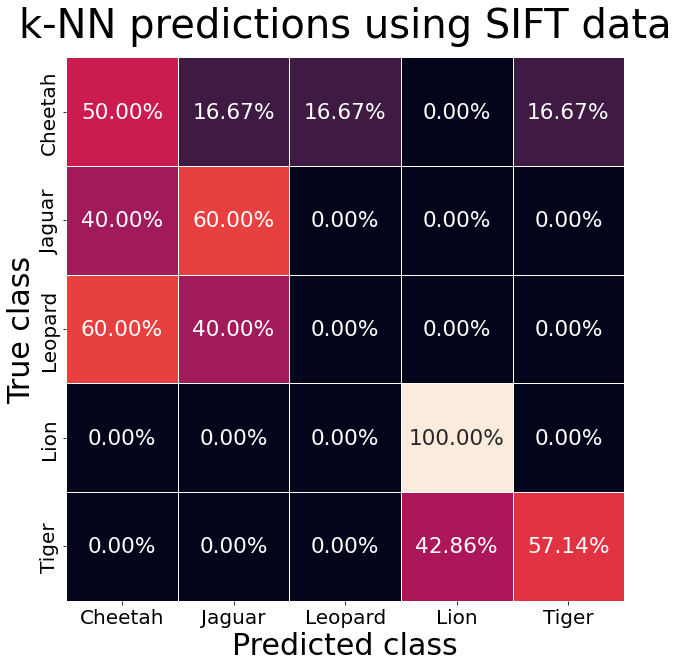

In [22]:
# # Create the 80/20 split
x_train, x_test, y_train, y_test = train_test_split(data_vec_8020, labels_8020, test_size=0.2, random_state=42, stratify=labels_8020)

# # Tune k using gridsearch on the train set
# # knn_gridsearch(x_train, y_train, [k for k in range(1,21,2)])

# # Train using the optimal k (=5) and test on the test set
acc, f1, pred_labels = knn(x_train, y_train, x_test, y_test, k=7)
print(f'Accuracy = {acc} - F1-score = {f1}')

# # Show a confusion matrix
# create_conf_matrix(y_test, pred_labels, title="k-NN predictions using SIFT data")

**Fourier (best k = 17 [0.361922, 0.300549])**

In [39]:
# Create the 80/20 split
x_train, x_test, y_train, y_test = train_test_split(ft_img_data, img_labels, test_size=0.2, random_state=42, stratify=img_labels)

# Tune k using gridsearch on the train set
# knn_gridsearch(x_train, y_train, [k for k in range(1,21,2)])

# Train using the optimal k (=5) and test on the test set
acc, f1, pred_labels = knn(x_train, y_train, x_test, y_test, k=17)
print(f'Accuracy = {acc} - F1-score = {f1}')

# Show a confusion matrix
# create_conf_matrix(y_test, pred_labels, title="k-NN predictions using FT data")

Accuracy = 0.4411764705882353 - F1-score = 0.3927932576539388


### k-NN - BigCats - Cross Validation
**Raw data (best k = 7 [0.384967, 0.247059])**

In [40]:
# Tune k using gridsearch on the entire data set
# knn_gridsearch(img_data, img_labels, [k for k in range(1,21,2)])

# Evaluate with the optimal k (=k) using cross validation
acc, f1 = knn_cross_validation(img_data, img_labels, k=7)
print(f'Accuracy = {acc} - F1-score = {f1}')

Accuracy = 0.24705882352941178 - F1-score = 0.2068569992099404


**SIFT (best k = k)**

In [11]:
acc, f1 = knn_cross_validation(data_vec_8020, labels_8020, k=7)
print(f'Accuracy = {acc} - F1-score = {f1}')

Accuracy = 0.4791208791208791 - F1-score = 0.4430913134484563


**Fourier (best k = 13 [0.425490, 0.382353])**

In [41]:
# Tune k using gridsearch on the entire data set
# knn_gridsearch(ft_img_data, img_labels, [k for k in range(1,21,2)])

# Evaluate with the optimal k (=k) using cross validation
acc, f1 = knn_cross_validation(ft_img_data, img_labels, k=13)
print(f'Accuracy = {acc} - F1-score = {f1}')

Accuracy = 0.38235294117647056 - F1-score = 0.33473941091588155


### Logistic Regression - BigCats - 80/20
**Raw data (best solver = lbfgs, best C = 1)**

In [14]:
# Create the 80/20 split
x_train, x_test, y_train, y_test = train_test_split(img_data, img_labels, test_size=0.2, random_state=42, stratify=img_labels)

# Tune k using gridsearch on the train set
# solvers = ["newton-cg", "lbfgs", "liblinear"]
# c_values = [0.1, 1, 10, 100]
# logistic_regression_gridsearch(x_train, y_train, solvers, c_values)

# Train using the optimal k (=k) and test on the test set
acc, f1, pred_labels = logistic_regression(x_train, y_train, x_test, y_test, solver="lbfgs", c_value=1)
print(f'Accuracy = {acc} - F1-score = {f1}')

# Show a confusion matrix
# create_conf_matrix(y_test, pred_labels, title="Logistic regression predictions using raw data")

Accuracy = 0.3235294117647059 - F1-score = 0.29150326797385623


**SIFT (best solver = x, best C = y)**

Accuracy = 0.6071428571428571 - F1-score = 0.5558441558441558


/home/abe/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


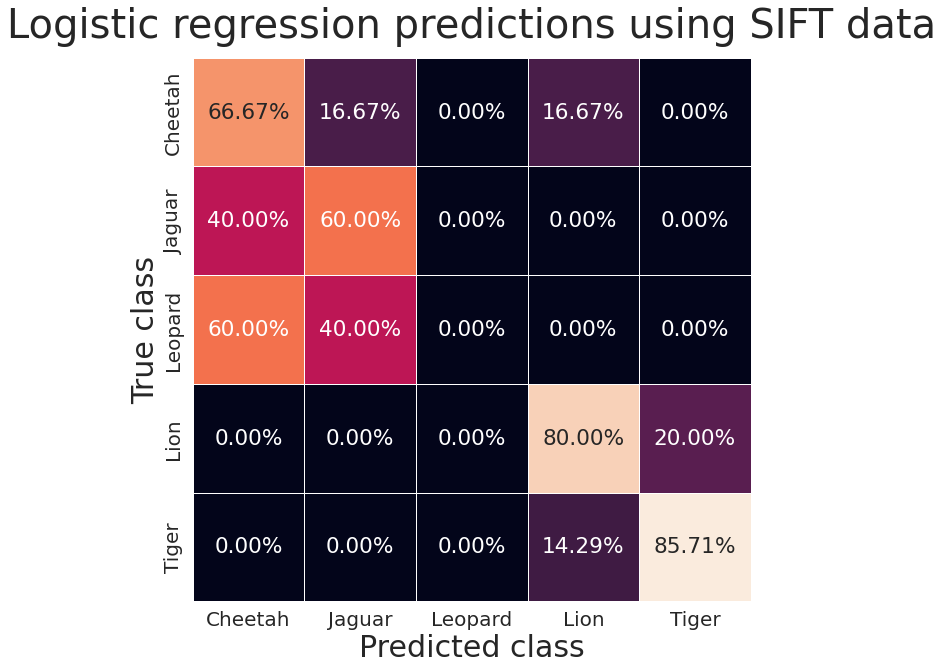

In [25]:
# # Create the 80/20 split
x_train, x_test, y_train, y_test = train_test_split(data_vec_8020, labels_8020, test_size=0.2, random_state=42, stratify=labels_8020)

# # Tune k using gridsearch on the train set
# solvers = ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
# c_values = [0.0001, 0.001, 0.1, 1, 10, 100, 1000, 10000]
# logistic_regression_gridsearch(x_train, y_train, solvers, c_values)

# # Train using the optimal k (=k) and test on the test set
acc, f1, pred_labels = logistic_regression(x_train, y_train, x_test, y_test, solver="lbfgs", c_value=0.1)
print(f'Accuracy = {acc} - F1-score = {f1}')

# # Show a confusion matrix
create_conf_matrix(y_test, pred_labels, title="Logistic regression predictions using SIFT data")

**Fourier (best solver = liblinear, best C = 0.1)**

In [4]:
# Create the 80/20 split
x_train, x_test, y_train, y_test = train_test_split(ft_img_data, img_labels, test_size=0.2, random_state=42, stratify=img_labels)

# Tune k using gridsearch on the train set
# solvers = ["newton-cg", "lbfgs", "liblinear"]
# c_values = [0.1, 1, 10, 100]
# logistic_regression_gridsearch(x_train, y_train, solvers, c_values)

# Train using the optimal k (=k) and test on the test set
acc, f1, pred_labels = logistic_regression(x_train, y_train, x_test, y_test, solver="liblinear", c_value=0.1)
print(f'Accuracy = {acc} - F1-score = {f1}')

# Show a confusion matrix
# create_conf_matrix(y_test, pred_labels, title="Logistic regression predictions using FT data")

Accuracy = 0.4411764705882353 - F1-score = 0.4169185460745563


### Logistic Regression - BigCats - Cross Validation
**Raw data  (best solver = liblinear, best C = 0.1)**

In [4]:
# Tune the solver and C parameters using gridsearch on the entire data set
# solvers = ["newton-cg", "lbfgs", "liblinear"]
# c_values = [0.1, 1, 10, 100]
# logistic_regression_gridsearch(img_data, img_labels, solvers, c_values)

# Evaluate with the optimal k (=k) using cross validation
acc, f1 = logistic_regression_cross_validation(img_data, img_labels, solver="liblinear", c_value=0.1)
print(f'Accuracy = {acc} - F1-score = {f1}')

Accuracy = 0.27647058823529413 - F1-score = 0.25509506833036244


**SIFT  (best solver = x, best C = y)**

In [17]:
# # Tune the solver and C parameters using gridsearch on the entire data set
# solvers = ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
# c_values = [0.1, 1, 10, 100]
# logistic_regression_gridsearch(sift_img_data, img_labels, solvers, c_values)

# # Evaluate with the optimal k (=k) using cross validation
acc, f1 = logistic_regression_cross_validation(data_vec_8020, labels_8020, solver="liblinear", c_value=10)
print(f'Accuracy = {acc} - F1-score = {f1}')

Accuracy = 0.5423076923076924 - F1-score = 0.5105860805860807


**Fourier (best solver = linear, best C = 0.1)**

In [5]:
# Tune the solver and C parameters using gridsearch on the entire data set
# solvers = ["newton-cg", "lbfgs", "liblinear"]
# c_values = [0.1, 1, 10, 100]
# logistic_regression_gridsearch(ft_img_data, img_labels, solvers, c_values)

# Evaluate with the optimal k (=k) using cross validation
acc, f1 = logistic_regression_cross_validation(ft_img_data, img_labels, solver="liblinear", c_value=0.1)
print(f'Accuracy = {acc} - F1-score = {f1}')

Accuracy = 0.39999999999999997 - F1-score = 0.35637000254647316


### Naive Bayes

#### 80/20 split

#### K-fold

### Decision Trees

#### Parameter Sweep

In [8]:
print("Performing parameter sweep...")
accuracies = []
depths = [3,4,5,6,7,8,9,10]
for depth in depths:
    print(f"Trying max depth of {depth}...", end='\r')
    accuracies.append(decision_tree(num_data, num_labels)[0])
print(accuracies)
best_depth = depths[accuracies.index(max(accuracies))]
print(f"test accuracy: {max(accuracies)} for depth {depths[accuracies.index(max(accuracies))]}")

Performing parameter sweep...
[0.9813664596273292, 0.9627329192546584, 0.9751552795031055, 0.968944099378882, 0.9875776397515528, 0.9875776397515528, 0.9565217391304348, 0.968944099378882]
test accuracy: 0.9875776397515528 for depth 7


#### 80/20 split

In [10]:
# Raw data
print("using decision tree classifier on genes raw")
accuracy, f1_score, y_pred = decision_tree(num_data, num_labels, depth=best_depth)
print(f"test accuracy & f1: {accuracy, f1_score}")
#create_conf_matrix(num_labels, y_pred)

# PCA data
print("using decision tree classifier on genes PCA")
accuracy, f1_score, y_pred = decision_tree(pca_num_data, num_labels, depth=best_depth)
print(f"test accuracy & f1: {accuracy, f1_score}")
#create_conf_matrix(num_labels, y_pred)

# MI data
print("using decision tree classifier on genes MI")
accuracy, f1_score, y_pred = decision_tree(mi_num_data, num_labels, depth=best_depth)
print(f"test accuracy & f1: {accuracy, f1_score}")
#create_conf_matrix(num_labels, y_pred)



using decision tree classifier on genes raw
test accuracy & f1: (0.9813664596273292, 0.981386992454186)
using decision tree classifier on genes PCA
test accuracy & f1: (0.9006211180124224, 0.898379039885027)
using decision tree classifier on genes MI
test accuracy & f1: (0.9751552795031055, 0.9753293590801105)


#### K-fold

In [14]:
k = 10
# Raw data
print(f"using decision tree classifier on genes raw with {k}-fold")
accuracy, f1 = cross_val_decision_tree(num_data, num_labels, cv=k, depth=best_depth)
print("%0.3f test accuracy with a standard deviation of %0.3f" % (accuracy.mean(), accuracy.std()))
print("%0.3f test f1 with a standard deviation of %0.3f" % (f1.mean(), f1.std()))

# PCA data
print(f"using decision tree classifier on genes PCA with {k}-fold")
accuracy, f1 = cross_val_decision_tree(pca_num_data, num_labels, cv=k, depth=best_depth)
print("%0.3f test accuracy with a standard deviation of %0.3f" % (accuracy.mean(), accuracy.std()))
print("%0.3f test f1 with a standard deviation of %0.3f" % (f1.mean(), f1.std()))

# MI data
print(f"using decision tree classifier on genes MI with {k}-fold")
accuracy, f1 = cross_val_decision_tree(mi_num_data, num_labels, cv=k, depth=best_depth)
print("%0.3f test accuracy with a standard deviation of %0.3f" % (accuracy.mean(), accuracy.std()))
print("%0.3f test f1 with a standard deviation of %0.3f" % (f1.mean(), f1.std()))

using decision tree classifier on genes raw with 10-fold
0.980 test accuracy with a standard deviation of 0.000
0.980 test f1 with a standard deviation of 0.000
using decision tree classifier on genes PCA with 10-fold
0.916 test accuracy with a standard deviation of 0.000
0.916 test f1 with a standard deviation of 0.000
using decision tree classifier on genes MI with 10-fold
0.984 test accuracy with a standard deviation of 0.000
0.984 test f1 with a standard deviation of 0.000


### SVM- BigCats - 80/20
**Raw data (best C=10 kernel='rbf',gamma=0.001)**

In [6]:
#tuning hyperparameters using grid search
#svm_images_gridsearch(img_data, img_labels)

X_train, X_test, y_train, y_test = train_test_split(img_data, img_labels,test_size=0.2,random_state=77,stratify=img_labels)
acc, f1, pred_labels =svm_images(X_train, X_test, y_train, y_test,C=10,kernel='rbf',gamma=0.001)
print(f'Accuracy = {acc} - F1-score = {f1}')

svm train start
new model saved
accuracy on the training subset:0.978
accuracy on the test subset:0.265
Accuracy = 0.2647058823529412 - F1-score = 0.14695108812755872


**SIFT  (best C=10 kernel='rbf',gamma=0.000001)**

In [7]:
#tuning hyperparameters using grid search
#svm_images_gridsearch()

acc, f1, pred_labels =svm_images_sift(data_vec_8020, X_test_sift, labels_8020, y_test_sift,C=10,kernel='rbf',gamma=0.00001)
print(f'Accuracy = {acc} - F1-score = {f1}')

svm train start
new model saved
data_vec: (34, 50)
image features extration done!
accuracy on the training subset:0.912
accuracy on the test subset:0.559
Accuracy = 0.5588235294117647 - F1-score = 0.5606981254040078


**Fourier (best C=10 kernel='rbf',gamma=0.001)**

In [6]:
#tuning hyperparameters using grid search
#svm_images_gridsearch(ft_img_data, img_labels)

X_train, X_test, y_train, y_test = train_test_split(ft_img_data, img_labels,test_size=0.2,random_state=77,stratify=img_labels)
acc, f1, pred_labels =svm_images(X_train, X_test, y_train, y_test,C=10,kernel='rbf',gamma=0.001)
print(f'Accuracy = {acc} - F1-score = {f1}')

svm train start
new model saved
accuracy on the training subset:0.978
accuracy on the test subset:0.265
Accuracy = 0.2647058823529412 - F1-score = 0.14695108812755872


### SVM - BigCats - Cross Validation
**Raw data  (best C=10 kernel='rbf',gamma=0.00001)**

In [9]:
# Evaluate with the optimal hyperparameters using cross validation
acc, f1 = svm_images_cross_val(img_data, img_labels,n_splits = 10,C=10,kernel='rbf',gamma=0.00001)
print(f'Accuracy = {acc} - F1-score = {f1}')

svm train start
Accuracy = 0.2529411764705882 - F1-score = 0.13330324080096437


**SIFT  (best C=10 kernel='rbf',gamma=0.00001)**

In [11]:
#tuning hyperparameters using grid search
#svm_images_gridsearch()
acc, f1 = svm_images_cross_val(data_vec_cv,labels_cv,n_splits = 10,C=10,kernel='rbf',gamma=0.00001)
print(f'Accuracy = {acc} - F1-score = {f1}')

svm train start
Accuracy = 0.5529411764705883 - F1-score = 0.5365448603683898


**Fourier (best C=10 kernel='rbf',gamma=0.001)**

In [5]:
# Evaluate with the optimal hyperparameters using cross validation
acc, f1 = svm_images_cross_val(ft_img_data, img_labels,n_splits = 5,C=10,kernel='rbf',gamma=0.001)
print(f'Accuracy = {acc} - F1-score = {f1}')

svm train start
Accuracy = 0.24705882352941178 - F1-score = 0.1196152290843826


## Clustering

### K-Means

In [21]:
# RAW
sil_score, rand_score, mi_score = kmeans_train(img_data, img_labels)
print(f"sil: {sil_score}, rand: {rand_score}, mi: {mi_score}")
# SIFT
sil_score, rand_score, mi_score = kmeans_train(data_vec_8020, labels_8020)
print(f"sil: {sil_score}, rand: {rand_score}, mi: {mi_score}")
# FT
sil_score, rand_score, mi_score = kmeans_train(ft_img_data, img_labels)
print(f"sil: {sil_score}, rand: {rand_score}, mi: {mi_score}")

sil: 0.074832954599746, rand: -0.005792197452229299, mi: -0.016625600598516307
sil: 0.17258331163052024, rand: 0.12951721178937595, mi: 0.17392170946840202
sil: 0.017102167456584, rand: 0.0036489072274082652, mi: 0.0016295791488391991


### Fuzzy C-Means

In [20]:
print("RAW NUM")
print(fuzzy_c_means(num_data, 5))
print("PCA NUM")
print(fuzzy_c_means(pca_num_data, 5))
print("MI NUM")
print(fuzzy_c_means(mi_num_data, 5))


RAW NUM
fcm.partition_coefficient=0.040000000000024766
fcm.partition_entropy_coefficient=0.4643856189773832
sil_score=0.12519651029604648


AttributeError: 'int' object has no attribute 'to_numpy'

# Data augmentation

In [26]:
from raw_data.data_functions import load_augmented_img_data
aug_img_data, aug_img_labels = load_augmented_img_data()

build_center(X_train_sift) # the input data should be training data
data_vec_8020,labels_8020 = cal_vec(X_train_sift, y_train_sift) # the input data should be training data


Vocabulary saved: (50, 128)
data_vec: (136, 50)
image features extration done!


In [27]:
from sklearn.model_selection import train_test_split
from classification.logistic_regression import logistic_regression

x_train, x_test, y_train, y_test = train_test_split(aug_img_data, aug_img_labels, test_size=0.2, random_state=42)
acc, f1, pred_labels = logistic_regression(x_train, y_train, x_test, y_test, solver="liblinear", c_value=0.1)
print(f'Accuracy = {acc} - F1-score = {f1}')

# Show a confusion matrix
# create_conf_matrix(y_test, pred_labels, title="Logistic regression predictions using FT data")

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [28]:
x_train, x_test, y_train, y_test = train_test_split(data_vec_8020, labels_8020, test_size=0.2, random_state=42)

acc, f1, pred_labels = logistic_regression(x_train, y_train, x_test, y_test, solver="liblinear", c_value=0.1)
print(f'Accuracy = {acc} - F1-score = {f1}')

Accuracy = 0.5357142857142857 - F1-score = 0.5345368916797488


/home/abe/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


-----------------------------------------------------
*end*